# 示例策略：多空概率简单预测
接下来我们将展示一个示例策略，这个策略使用一个自定义的 Kera 神经网络进行多空预测，根据预测结果进行交易决策。

要运行这个实验，请选择 conda_tensorflow2_p36 内核。

在开始之前，我们先确保 Tensorflow 和 Keras 的版本：

In [1]:
!pip show tensorflow keras

Name: tensorflow
Version: 2.3.4
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages
Requires: grpcio, tensorboard, absl-py, astunparse, google-pasta, six, opt-einsum, termcolor, keras-preprocessing, tensorflow-estimator, h5py, wheel, numpy, protobuf, gast, wrapt
Required-by: tensorflow-serving-api, ei-for-tf
---
Name: Keras
Version: 2.4.3
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages
Requires: scipy, h5py, pyyaml, numpy
Required-by: 


建议使用 tensorflow=2.3.4 和 keras=2.4.3 进行实验。如果有问题，可以尝试重新安装这两个库：

In [2]:
# !pip uninstall -y tensorflow keras
# !pip install tensorflow==2.3.4 keras==2.4.3

### 定义参数

我们首先定义一些实验需要用到的环境变量：

In [12]:
import boto3

aws_account_id = boto3.client('sts').get_caller_identity().get('Account')
repository_name = 'long-short-predict'
aws_region = 'us-east-1'
my_name = 'peng'
bucket = 'algo-trading-workshop-{}'.format(my_name)

### 获取数据

与之前实验的一样，我们选择一支股票，然后通过 Athena 获取行情数据：

In [4]:
!pip install awswrangler

import awswrangler as wr

s3_output = wr.athena.create_athena_bucket()

def execute_query(database, sql):
    
    query_execution_id = wr.athena.start_query_execution(database=database, sql=sql)
    response = wr.athena.get_query_execution(query_execution_id=query_execution_id)
    wr.athena.wait_query(query_execution_id=query_execution_id)
    OutputLocation = response['ResultConfiguration']['OutputLocation']
    
    return OutputLocation

  Using cached awswrangler-2.13.0-py3-none-any.whl (222 kB)
  Using cached PyMySQL-1.0.2-py3-none-any.whl (43 kB)
  Using cached opensearch_py-1.0.0-py2.py3-none-any.whl (207 kB)
  Using cached redshift_connector-2.0.901-py3-none-any.whl (94 kB)
  Using cached requests_aws4auth-1.1.1-py2.py3-none-any.whl (31 kB)
     |████████████████████████████████| 8.4 MB 25.0 MB/s eta 0:00:01
  Using cached pg8000-1.22.1-py3-none-any.whl (33 kB)
  Using cached jsonpath_ng-1.5.3-py3-none-any.whl (29 kB)
  Using cached progressbar2-3.55.0-py2.py3-none-any.whl (26 kB)
     |████████████████████████████████| 131 kB 85.3 MB/s eta 0:00:01
  Using cached scramp-1.4.1-py3-none-any.whl (8.5 kB)
  Using cached python_utils-2.5.6-py2.py3-none-any.whl (12 kB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.23.3
    Uninstalling botocore-1.23.3:
      Successfully uninstalled botocore-1.23.3
  Attempting uninstall: boto3
    Found existing installation: boto3 1.20.3
    Uninstalling

In [13]:
database = 'stock-data'
table = 'stock_day'
fields = '*'
ticker = '600519'
orderby = 'tradedate'
sort = 'ASC'

sql = f'''
SELECT {fields}
FROM "{database}"."{table}"
WHERE ticker='{ticker}'
AND tradedate>='2015-01-01'
ORDER BY {orderby}
{sort}
'''

output_location = execute_query(database, sql)
print(output_location)

s3://aws-athena-query-results-364198545638-us-east-1/5b7bc731-4a1a-4f79-9ec7-0f2f71ba795d.csv


In [14]:
df = wr.s3.read_csv(path=[output_location])

df['ticker'] = df['ticker'].apply(lambda x: str(x))
df['ticker'] = df['ticker'].apply(lambda x: '0'*(6-len(x)) + x)
df['openprice'] = df['openprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
df['closeprice'] = df['closeprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
df['highestprice'] = df['highestprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
df['lowestprice'] = df['lowestprice'] * df['accumadjfactor'] / df['accumadjfactor'].iloc[-1]
df = df[df['isopen'] == True]
df.drop('isopen', 1, inplace=True)
df.drop('accumadjfactor', 1, inplace=True)
df.set_index('tradedate', inplace=True)
df.sort_index(0, inplace=True)

df.rename(columns={'openprice': 'open'}, inplace=True)
df.rename(columns={'closeprice': 'close'}, inplace=True)
df.rename(columns={'highestprice': 'high'}, inplace=True)
df.rename(columns={'lowestprice': 'low'}, inplace=True)
df.rename(columns={'turnovervol': 'volume'}, inplace=True)
df['openinterest'] = 0 # A股回测中一般并不考虑利率，通常可以直接设为 0
df.head()

,ticker,secid,open,high,low,close,volume,turnovervalue,openinterest
tradedate,,,,,,,,,
2015-01-05,600519,600519.SH,155.403715,167.385585,154.641530,165.975953,9451517.0,1.875063e+09,0
2015-01-06,600519,600519.SH,163.910679,166.008736,160.648856,162.132248,5502001.0,1.094977e+09,0
2015-01-07,600519,600519.SH,160.665247,163.500902,155.706949,158.124632,5479784.0,1.063926e+09,0
2015-01-08,600519,600519.SH,158.993358,159.419526,155.829882,157.157559,4052530.0,7.778747e+08,0
2015-01-09,600519,600519.SH,156.042966,160.443968,155.805296,155.969206,5398220.0,1.039955e+09,0


In [15]:
!mkdir -p {repository_name}/input/data
df.to_csv('{}/input/data/data_raw.csv'.format(repository_name))

### 定义超参

在开始之前我们先定义一下这个算法中包含几个重要的参数：
- long_threshold：当模型预测止盈概率超过此数值时做多 (0 到 1 之间的小数)。
- short_threshold：当模型预测止损概率超过此数值时做空 (0 到 1 之间的小数)。如果设为大于等于 1，策略就不会做空。
- profit_target：当交易盈利超过此比例时止盈（0 到 1 之间的小数）。
- stop_target：当交易损失超过此比例时止损（0 到 1 之间的小数）。
- look_back：每次预测使用过去多少个交易日（整数）的历史数据。（look_back = repeat_count * repeat_step）
- forward_window：每次预测向前推导多少个交易日（整数）。

In [16]:
!mkdir {repository_name}

mkdir: cannot create directory ‘long-short-predict’: File exists


In [17]:
params = { 
    "long_threshold" : 0.5,
    "short_threshold" : 1,
    "profit_target" : 0.02,
    "stop_target" : 0.01,
    "repeat_count": 20,
    "repeat_step": 1,
    "forward_window": 10
}

long_threshold = params['long_threshold']
short_threshold = params['short_threshold']
profit_target = params['profit_target']
stop_target = params['stop_target']

repeat_count = params['repeat_count']
repeat_step = params['repeat_step']
look_back = repeat_count * repeat_step
forward_window = params['forward_window']

# 将参数以 json 格式保存至指定目录
import json

with open('{}/hyperparameters.json'.format(repository_name), 'w') as fp:
    json.dump(params, fp)

### 模型训练

在这个演示中，我们获取了 2010 年至今的数据用于模型训练和预测。这个训练过程将运行 100 个 epoch：

In [18]:
!pip install backtrader
!pip uninstall -y matplotlib
!pip install matplotlib==3.1.3
!pip install talib-binary

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.
Found existing installation: matplotlib 3.1.3
Uninstalling matplotlib-3.1.3:
  Successfully uninstalled matplotlib-3.1.3
  Using cached matplotlib-3.1.3-cp36-cp36m-manylinux1_x86_64.whl (13.1 MB)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [19]:
from __future__ import print_function

import datetime
import math
import numpy as np
import os
import pandas as pd
import sys
import talib as ta
import traceback

from keras.layers import Dropout, Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor


# Optional
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

config_path = '{}/'.format(repository_name)
input_path = '{}/input/data/data_train.csv'.format(repository_name)
raw_path = '{}/input/data/data_raw.csv'.format(repository_name)
train_path = '{}/input/data/data_train.csv'.format(repository_name)
test_path = '{}/input/data/data_test.csv'.format(repository_name)
output_path = '{}/output'.format(repository_name)
model_path = '{}/model.h5'.format(repository_name)


# Process and prepare the data
def get_data(params):
    
    # get and save hyperparameters
    long_threshold = float(params['long_threshold'])
    short_threshold = float(params['short_threshold'])
    profit_target = float(params['profit_target'])
    stop_target = float(params['stop_target'])

    repeat_count = int(params['repeat_count'])
    repeat_step = int(params['repeat_step'])
    look_back = repeat_count * repeat_step
    forward_window = int(params['forward_window'])
    
    # read data from s3
    df = pd.read_csv(raw_path, index_col=0)
    closePrice = df["close"]

    # use talib to calculate SMA and ROC
    ## set header for transformed data
    header = ["tradedate", "close"]
    for i in range(0, repeat_count):
        header.append("sma" + str((i+1) * repeat_step))
    for i in range(0, repeat_count):
        header.append("roc" + str((i+1) * repeat_step))
    header.append("long")
    header.append("short")

    data = []

    ## SMA
    inputs = {'close': np.array(closePrice)}
    sma = []
    for i in range(0, repeat_count):
        sma.append(ta.SMA(np.array(closePrice), timeperiod=(i+1) * repeat_step + 1))
    ## ROC - Rate of change : ((price/prevPrice)-1)*100
    roc = []
    for i in range(0, repeat_count):
        roc.append(ta.ROC(np.array(closePrice), timeperiod=(i+1) * repeat_step + 1))

    ## count long and short
    long_count = 0
    short_count = 0
    n_count = 0
    n = 0
    for idx in df.index:
        if n < len(df) - forward_window - 1:
            idx_0 = idx
            close_price = df.loc[idx, 'close']
            temp = []
            temp.append(idx)

            temp2 = []
            temp2.append(close_price)

            # sma
            for i in range(0, repeat_count):
                if np.isnan(sma[i][n]):
                    temp2.append(close_price)
                else:
                    temp2.append(sma[i][n])

            min_value = min(temp2)
            max_value = max(temp2)
            for i in temp2:
                if max_value == min_value:
                    temp.append(0)
                else:
                    temp.append((i - min_value) / (max_value - min_value))

            for i in range(0, repeat_count):
                if np.isnan(roc[i][n]):
                    temp.append(0)
                else:
                    temp.append(roc[i][n])

            rClose = closePrice[(n+1):min(len(df)-1, n+1+forward_window)].values.tolist()
            min_value = min(rClose)
            max_value = max(rClose)

            # long condition
            if max_value >= close_price * (1+profit_target) and min_value >= close_price * (1-stop_target):
                long_count += 1
                temp.append(1)
            else:
                temp.append(0)

            # short condition
            if min_value <= close_price * (1-stop_target) and max_value <= close_price * (1+profit_target):
                short_count += 1
                temp.append(1)
            else:
                temp.append(0)

            data.append(temp)
            n += 1

    print("long：%s, short：%s" % (long_count,short_count))
    df2 = pd.DataFrame(data, columns=header)
    df2.set_index('tradedate', inplace=True)
    print('Range:', df2.index[0], '-', df2.index[-1])
    
    # save data
    df_train = df2.iloc[:800]
    print('Training set:', df_train.index[0], '-', df_train.index[-1])
    print('Location:', train_path)
    df_train.to_csv(train_path)

    df_test = df2.iloc[800:1000]
    print('Testing set:', df_test.index[0], '-', df_test.index[-1])
    print('Location:', test_path)
    df_test.to_csv(test_path)
    

# Process and prepare the data
def data_process(df, yLen, b):
    
    dataX = []
    dataY = []
    for idx, row in df.iterrows():
        row1 = []
        r = row[1:len(row)-yLen]
        for a in r:
            row1.append(a)
        x = np.array(row1, dtype=float)
        y = np.array(row[len(row)-yLen:], dtype=float)
        b = len(x)
        dataX.append(x)
        dataY.append(y)
        
    dataX = np.array(dataX)
    dataY = np.array(dataY)
    
    return dataX, dataY, b


def build_classifier(b, yLen):
    
    print("build_classifier:b=%s,yLen=%s" % (b, yLen))
    model = Sequential()
    model.add(Dense(b, input_dim=b, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(int(b/2), kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(yLen, kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


def generate_model(dataX, dataY, b, yLen):
    
    model = build_classifier(b, yLen)
    model.fit(dataX, dataY, epochs=100, batch_size=1)
    scores = model.evaluate(dataX, dataY, verbose=0)
    print("Training Data %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    
    return model


def train():
    
    try:
        with open("{}/hyperparameters.json".format(config_path)) as json_file:
            params = json.load(json_file)
        print('Parameter load success')
    except Exception as e:
        print(e)

    get_data(params)
    
    print('Starting the training.')
    
    yLen = 2
    b = 0
    
    try:
        
        df = pd.read_csv(input_path)
        dataX, dataY, b = data_process(df, yLen, b)
        print('b:', b, 'yLen:', yLen)
        model = generate_model(dataX, dataY, b, yLen)
        model.save(model_path)
        
        print('Training is complete. Model saved.')
        
        df = pd.read_csv(test_path)
        dataX, dataY, b = data_process(df, yLen, b)
        print('b:', b, 'yLen:', yLen)
        scores = model.evaluate(dataX, dataY, verbose=0)
        print("Test Data %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        
    except Exception as e:
        # Write out an error file. This will be returned as the failure
        # Reason in the DescribeTrainingJob result.
        trc = traceback.format_exc()
        with open(os.path.join(output_path, 'failure'), 'w') as s:
            s.write('Exception during training: ' + str(e) + '\n' + trc)
        # Printing this causes the exception to be in the training job logs
        print(
            'Exception during training: ' + str(e) + '\n' + trc,
            file=sys.stderr)
        # A non-zero exit code causes the training job to be marked as Failed.
        sys.exit(255)

        
if __name__ == '__main__':
    train()

    # A zero exit code causes the job to be marked a Succeeded.
    sys.exit(0)

Parameter load success
long：598, short：483
Range: 2015-01-05 - 2021-06-18
Training set: 2015-01-05 - 2018-04-19
Location: long-short-predict/input/data/data_train.csv
Testing set: 2018-04-20 - 2019-02-15
Location: long-short-predict/input/data/data_test.csv
Starting the training.
b: 41 yLen: 2
build_classifier:b=41,yLen=2
Epoch 1/100
800/800 [==============================] - 1s 1ms/step - loss: 0.6548 - accuracy: 0.5925
Epoch 2/100
800/800 [==============================] - 1s 832us/step - loss: 0.6415 - accuracy: 0.6250
Epoch 3/100
800/800 [==============================] - 1s 836us/step - loss: 0.6387 - accuracy: 0.6175
Epoch 4/100
800/800 [==============================] - 1s 824us/step - loss: 0.6375 - accuracy: 0.6200
Epoch 5/100
800/800 [==============================] - 1s 818us/step - loss: 0.6347 - accuracy: 0.5962
Epoch 6/100
800/800 [==============================] - 1s 833us/step - loss: 0.6309 - accuracy: 0.6300
Epoch 7/100
800/800 [==============================] - 1s 82

SystemExit: 0

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


看到 SystemExit: 0 则表明模型训练成功。

训练完成后的模型保存在 model/ 路径下，应该可以看到路径下有名为 model.h5 的模型文件生成。可以运行以下代码尝试在 TensorFlow 中加载模型：

In [20]:
from keras.models import load_model

model_path = '{}/model.h5'.format(repository_name)
print('Model path:', model_path)
try:
    model = load_model(model_path)
    print('Model load success')
    
except Exception as e:
    print(e)

Model path: long-short-predict/model.h5
Model load success


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 41)                1722      
_________________________________________________________________
dropout (Dropout)            (None, 41)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                840       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 42        
Total params: 2,604
Trainable params: 2,604
Non-trainable params: 0
_________________________________________________________________


### 运行回测

接下来我们将定义运行回测任务，看看模型在实际回测中的表现。这个回测任务将使用除了训练和测试集之外的交易日作为样本。

In [22]:
# 回测数据
df_backtest= df.iloc[1000:]
print('Backtest set:', df_backtest.index[0], '-', df_backtest.index[-1])
df_backtest.head()

# 超参
with open("{}/hyperparameters.json".format(repository_name)) as json_file:
    params = json.load(json_file)

Backtest set: 2019-02-18 - 2021-07-05


接下来的脚本包含了运行回测所需的策略代码。该策略将从示例的路径中加载之前训练好的模型。

In [23]:
import backtrader as bt
import json
import math
import numpy as np
import pandas as pd
import talib as ta

import keras
from keras import backend as K
from keras.models import load_model


class MyStrategy(bt.Strategy):
    
    params = (
        ('model_path', ''), 
        ('long_threshold', 0.5), 
        ('short_threshold', 1), 
        ('profit_target', 0.02), 
        ('stop_target', 0.01), 
        ('repeat_count', 20), 
        ('repeat_step', 1), 
        ('printlog', True))

    def __init__(self):
        super(MyStrategy, self).__init__()

        self.order = None
        self.orderPlaced = False
                                
        self.model = load_model(self.params.model_path)
        
        # input / indicators
        self.long_threshold = self.params.long_threshold
        self.short_threshold = self.params.short_threshold
        self.repeat_count = self.params.repeat_count
        self.repeat_step = self.params.repeat_step
        self.profit_target = self.params.profit_target
        self.stop_target = self.params.stop_target
    
        self.sma=[]
        self.roc=[]
        for i in range(0, self.repeat_count):
            self.sma.append(bt.talib.SMA(self.data, timeperiod=(i+1)*self.repeat_step + 1, plot=False))
            self.roc.append(bt.talib.ROC(self.data, timeperiod=(i+1)*self.repeat_step + 1, plot=False))
        
    def next(self):
        super(MyStrategy, self).next()
        
        idx_0 = self.datas[0].datetime.datetime(0)
        close_price = self.datas[0].close
        temp = []
        
        temp2 = []
        temp2.append(close_price)

        ## sma
        for i in range(0, self.repeat_count):
            if math.isnan(self.sma[i][0]):
                temp2.append(close_price)
            else:
                temp2.append(self.sma[i][0])
                
        min_value = min(temp2)
        max_value = max(temp2)
        for i in temp2:
            if max_value == min_value:
                temp.append(0)
            else:
                temp.append((i - min_value) / (max_value - min_value))

        ## roc
        for i in range(0, self.repeat_count):
            if math.isnan(self.roc[i][0]):
                temp.append(0)
            else:
                temp.append(self.roc[i][0])
        
        ## dataX
        dataX = np.array([np.array(temp)])

        ## dataY
        dataY = self.model.predict(dataX)
        
        
        ## 开仓条件
        tLong = dataY[0][0]
#         tShort = dataY[0][1]
        if not self.position:
            fLong = (tLong > self.long_threshold) 
#             fShort = (tShort > self.short_threshold)
            if fLong:
                self.size = int(self.broker.cash / self.datas[0].close[0])
                self.order = self.buy(size=self.size)
                self.limitPrice = close_price + self.profit_target * close_price
                self.stopPrice = close_price - self.stop_target * close_price
#             elif fShort:
#                 self.order = self.sell(size=self.size)                
#                 self.limitPrice = close_price - self.profit_target * close_price
#                 self.stopPrice = close_price + self.stop_target * close_price

        ## 平仓逻辑
        if self.position:
            if self.position.size > 0:
                if close_price >= self.limitPrice or close_price <= self.stopPrice:
                    self.order = self.sell(size=self.size)
#             elif self.position.size < 0:
#                 if close_price <= self.limitPrice or close_price >= self.stopPrice:
#                     self.order = self.buy(size=self.size)
                    
    ## 日志记录
    def log(self, txt, dt=None, doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()},{txt}')

    # 记录交易执行情况（可选，默认不输出结果）
    def notify_order(self, order):
        # 如果 order 为 submitted/accepted，返回空
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 如果 order 为 buy/sell executed，报告价格结果
        if order.status in [order.Completed]: 
            if order.isbuy():
                self.log(f'买入：\n价格：%.2f,\
                交易金额：-%.2f,\
                手续费：%.2f' % (order.executed.price, order.executed.value, order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log(f'卖出:\n价格：%.2f,\
                交易金额：%.2f,\
                手续费：%.2f' % (order.executed.price, order.executed.price*self.size, order.executed.comm))
            self.bar_executed = len(self) 

        # 如果指令取消/交易失败, 报告结果
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失败')
        self.order = None

    # 记录交易收益情况（可省略，默认不输出结果）
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        self.log(f'策略收益\n毛收益 {trade.pnl:.2f}, 净收益 {trade.pnlcomm:.2f}')

    # 回测结束后输出结果（可省略，默认输出结果）
    def stop(self):
        self.log('期末总资金 %.2f' %
                 (self.broker.getvalue()), doprint=True)

In [24]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime
import os.path
import sys

import backtrader as bt

if __name__ == '__main__':
    # 创建 Cerebro 对象
    cerebro = bt.Cerebro()

    # 创建 Data Feed
    df_backtest.index = pd.to_datetime(df_backtest.index)
    start = df_backtest.index[0]
    end = df_backtest.index[-1]
    print(start, '-', end)
    data = bt.feeds.PandasData(dataname=df_backtest, fromdate=start, todate=end)
    
    # 将 Data Feed 添加至 Cerebro
    cerebro.adddata(data)

    # 添加策略 Cerebro
    cerebro.addstrategy(MyStrategy, 
                        model_path=model_path,
                        long_threshold=params["long_threshold"], 
                        short_threshold=params["short_threshold"], 
                        profit_target=params["profit_target"], 
                        stop_target=params["stop_target"],
                        repeat_count=params["repeat_count"], 
                        repeat_step=params["repeat_step"])
    
    # 设置初始资金
    cerebro.broker.setcash(100000.0)
    # 设置手续费为万二
    cerebro.broker.setcommission(commission=0.0002) 

    # 在开始时 print 初始账户价值
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # 运行回测流程
    cerebro.run()

    # 在结束时 print 最终账户价值
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

2019-02-18 00:00:00 - 2021-07-05 00:00:00
Starting Portfolio Value: 100000.00
2019-03-29,交易失败
2019-04-09,交易失败
2019-04-10,买入：
价格：871.35,                交易金额：-99333.57,                手续费：19.87
2019-04-11,卖出:
价格：914.77,                交易金额：104283.74,                手续费：20.86
2019-04-11,策略收益
毛收益 4950.18, 净收益 4909.45
2019-04-26,买入：
价格：913.13,                交易金额：-104096.74,                手续费：20.82
2019-04-30,卖出:
价格：934.07,                交易金额：106483.82,                手续费：21.30
2019-04-30,策略收益
毛收益 2387.09, 净收益 2344.97
2019-05-10,交易失败
2019-05-13,买入：
价格：867.35,                交易金额：-105816.97,                手续费：21.16
2019-05-14,卖出:
价格：853.98,                交易金额：104185.32,                手续费：20.84
2019-05-14,策略收益
毛收益 -1631.65, 净收益 -1673.65
2019-05-24,交易失败
2019-05-27,买入：
价格：848.28,                交易金额：-105187.32,                手续费：21.04
2019-05-30,卖出:
价格：878.10,                交易金额：108884.61,                手续费：21.78
2019-05-30,策略收益
毛收益 3697.29, 净收益 3654.48
2019-06-11,买入：
价格：845.29,        

最后将回测结果进行可视化：

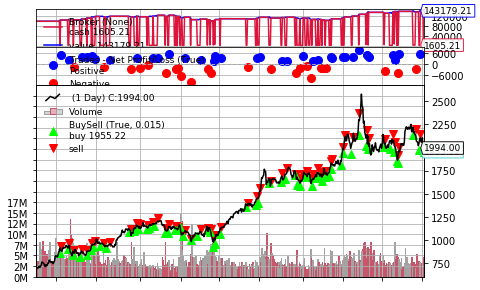

In [25]:
import matplotlib
%matplotlib inline

# 画图并保存
fig = cerebro.plot(iplot=False)[0][0]
fig.set_size_inches(30, 18)
fig.savefig('{}/plot.png'.format(repository_name), dpi=100)

### 超参优化

您可能注意到回测的收益率并不高。同时，模型的 test accuracy 也非常低。这可能是因为糟糕的超参导致的。

因此，我们可以尝试通过超参优化提升模型的效果。

#### 上传数据到 S3

我们首先将实验数据集上传到 S3 指定目录：

In [26]:
wr.s3.to_csv(df=df, path='s3://{}/{}/input/data_raw.csv'.format(bucket, repository_name))

{'paths': ['s3://algo-trading-workshop-peng/long-short-predict/input/data_raw.csv'],
 'partitions_values': {}}

#### 定义回测任务

首先我们先准备一个回测脚本：

In [27]:
!mkdir {repository_name}/model

In [28]:
%%writefile {repository_name}/model/train
#!/usr/bin/env python
from __future__ import print_function

import datetime
import json
import math
import numpy as np
import os
import pandas as pd
import sys
import talib as ta
import traceback

from keras.layers import Dropout, Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor


# Optional
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# These are the paths to where SageMaker mounts interesting things in your container.
prefix = '/opt/ml/'

config_path = os.path.join(prefix, 'input/config')
input_path = os.path.join(prefix, 'input/data/training')
raw_path = os.path.join(input_path, 'data_raw.csv')
train_path = os.path.join(input_path, 'data_train.csv')
test_path = os.path.join(input_path, 'data_test.csv')
output_path = os.path.join(prefix, 'output')
model_path = os.path.join(prefix, 'model')


# Process and prepare the data
def get_data(params):
    
    # get and save hyperparameters
    long_threshold = float(params['long_threshold'])
    short_threshold = float(params['short_threshold'])
    profit_target = float(params['profit_target'])
    stop_target = float(params['stop_target'])

    repeat_count = int(params['repeat_count'])
    repeat_step = int(params['repeat_step'])
    look_back = repeat_count * repeat_step
    forward_window = int(params['forward_window'])
    
    # read data from s3
    df = pd.read_csv(raw_path, index_col=0)
    closePrice = df["close"]

    # use talib to calculate SMA and ROC
    ## set header for transformed data
    header = ["tradedate", "close"]
    for i in range(0, repeat_count):
        header.append("sma" + str((i+1) * repeat_step))
    for i in range(0, repeat_count):
        header.append("roc" + str((i+1) * repeat_step))
    header.append("long")
    header.append("short")

    data = []

    ## SMA
    inputs = {'close': np.array(closePrice)}
    sma = []
    for i in range(0, repeat_count):
        sma.append(ta.SMA(np.array(closePrice), timeperiod=(i+1) * repeat_step + 1))
    ## ROC - Rate of change : ((price/prevPrice)-1)*100
    roc = []
    for i in range(0, repeat_count):
        roc.append(ta.ROC(np.array(closePrice), timeperiod=(i+1) * repeat_step + 1))

    ## count long and short
    long_count = 0
    short_count = 0
    n_count = 0
    n = 0
    for idx in df.index:
        if n < len(df) - forward_window - 1:
            idx_0 = idx
            close_price = df.loc[idx, 'close']
            temp = []
            temp.append(idx)

            temp2 = []
            temp2.append(close_price)

            # sma
            for i in range(0, repeat_count):
                if np.isnan(sma[i][n]):
                    temp2.append(close_price)
                else:
                    temp2.append(sma[i][n])

            min_value = min(temp2)
            max_value = max(temp2)
            for i in temp2:
                if max_value == min_value:
                    temp.append(0)
                else:
                    temp.append((i - min_value) / (max_value - min_value))

            for i in range(0, repeat_count):
                if np.isnan(roc[i][n]):
                    temp.append(0)
                else:
                    temp.append(roc[i][n])

            rClose = closePrice[(n+1):min(len(df)-1, n+1+forward_window)].values.tolist()
            min_value = min(rClose)
            max_value = max(rClose)

            # long condition
            if max_value >= close_price * (1+profit_target) and min_value >= close_price * (1-stop_target):
                long_count += 1
                temp.append(1)
            else:
                temp.append(0)

            # short condition
            if min_value <= close_price * (1-stop_target) and max_value <= close_price * (1+profit_target):
                short_count += 1
                temp.append(1)
            else:
                temp.append(0)

            data.append(temp)
            n += 1

    print("long：%s, short：%s" % (long_count,short_count))
    df2 = pd.DataFrame(data, columns=header)
    df2.set_index('tradedate', inplace=True)
    print('Range:', df2.index[0], '-', df2.index[-1])
    
    # save data
    df_train = df2.iloc[:800]
    print('Training set:', df_train.index[0], '-', df_train.index[-1])
    print('Location:', train_path)
    df_train.to_csv(train_path)

    df_test = df2.iloc[800:1000]
    print('Testing set:', df_test.index[0], '-', df_test.index[-1])
    print('Location:', test_path)
    df_test.to_csv(test_path)


def data_process(df, yLen, b):
    
    dataX = []
    dataY = []
    for idx, row in df.iterrows():
        row1 = []
        r = row[1:len(row)-yLen]
        for a in r:
            row1.append(a)
        x = np.array(row1, dtype=float)
        y = np.array(row[len(row)-yLen:], dtype=float)
        b = len(x)
        dataX.append(x)
        dataY.append(y)
        
    dataX = np.array(dataX)
    dataY = np.array(dataY)
    
    return dataX, dataY, b


def build_classifier(b, yLen):
    
    print("build_classifier:b=%s,yLen=%s" % (b, yLen))
    model = Sequential()
    model.add(Dense(b, input_dim=b, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(int(b/2), kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(yLen,kernel_initializer='normal', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


def generate_model(dataX, dataY, b, yLen):
    
    model = build_classifier(b, yLen)
    model.fit(dataX, dataY, epochs=100, batch_size=1)
    scores = model.evaluate(dataX, dataY, verbose=0)
    print("Training Data %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    
    return model


def train():
    
    try:
        with open("{}/hyperparameters.json".format(config_path)) as json_file:
            params = json.load(json_file)
        print('Parameter load success')
    except Exception as e:
        print(e)

    get_data(params)
    
    print('Starting the training.')
    
    yLen = 2
    b = 0
    
    try:
        
        df = pd.read_csv(train_path)
        dataX, dataY, b = data_process(df, yLen, b)
        print('b:', b, 'yLen:', yLen)
        model = generate_model(dataX, dataY, b, yLen)
        model.save(os.path.join(model_path, 'model.h5'))
        
        print('Training is complete. Model saved.')
        
        df = pd.read_csv(test_path)
        dataX, dataY, b = data_process(df, yLen, b)
        print('b:', b, 'yLen:', yLen)
        scores = model.evaluate(dataX, dataY, verbose=0)
        print("Test Data %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        
    except Exception as e:
        # Write out an error file. This will be returned as the failure
        # Reason in the DescribeTrainingJob result.
        trc = traceback.format_exc()
        with open(os.path.join(output_path, 'failure'), 'w') as s:
            s.write('Exception during training: ' + str(e) + '\n' + trc)
        # Printing this causes the exception to be in the training job logs
        print(
            'Exception during training: ' + str(e) + '\n' + trc,
            file=sys.stderr)
        # A non-zero exit code causes the training job to be marked as Failed.
        sys.exit(255)

        
if __name__ == '__main__':
    train()

    # A zero exit code causes the job to be marked a Succeeded.
    sys.exit(0)

Writing long-short-predict/model/train


#### 创建镜像仓库和容器镜像

接下来构建一个 python3 容器镜像和镜像仓库：

In [29]:
ecs = boto3.client('ecs', region_name=aws_region)
ecr = boto3.client('ecr', region_name=aws_region)

In [30]:
ecr.create_repository(repositoryName=repository_name)

{'repository': {'repositoryArn': 'arn:aws:ecr:us-east-1:364198545638:repository/long-short-predict',
  'registryId': '364198545638',
  'repositoryName': 'long-short-predict',
  'repositoryUri': '364198545638.dkr.ecr.us-east-1.amazonaws.com/long-short-predict',
  'createdAt': datetime.datetime(2021, 12, 10, 5, 27, 27, tzinfo=tzlocal()),
  'imageTagMutability': 'MUTABLE',
  'imageScanningConfiguration': {'scanOnPush': False},
  'encryptionConfiguration': {'encryptionType': 'AES256'}},
 'ResponseMetadata': {'RequestId': '296dfa9a-a80c-4f5c-b3d2-d79858ade0c9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '296dfa9a-a80c-4f5c-b3d2-d79858ade0c9',
   'date': 'Fri, 10 Dec 2021 05:27:26 GMT',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '408'},
  'RetryAttempts': 0}}

In [31]:
%%writefile {repository_name}/Dockerfile
FROM tensorflow/tensorflow:2.3.4

RUN pip install --upgrade pip

RUN pip --no-cache-dir install \
        keras==2.4.3 \
        pandas \
        talib-binary

ENV PYTHONUNBUFFERED=TRUE
ENV PYTHONDONTWRITEBYTECODE=TRUE
ENV PATH="/opt/ml/code:${PATH}"

RUN mkdir -p /opt/ml/input/data
RUN mkdir -p /opt/ml/input/config
RUN mkdir -p /opt/ml/code
RUN mkdir -p /opt/ml/failure
RUN mkdir -p /opt/ml/model
RUN mkdir -p /opt/ml/output

COPY model /opt/ml/code
RUN chmod -R 777 /opt/ml/code
WORKDIR /opt/ml/code

Writing long-short-predict/Dockerfile


In [32]:
!docker build {repository_name} -t {repository_name}

Sending build context to Docker daemon  1.366MB
Step 1/15 : FROM tensorflow/tensorflow:2.3.4
 ---> 4656a17ac67c
Step 2/15 : RUN pip install --upgrade pip
 ---> Running in 31bad8be44d1
  Attempting uninstall: pip
    Found existing installation: pip 20.2.4
    Uninstalling pip-20.2.4:
      Successfully uninstalled pip-20.2.4
Removing intermediate container 31bad8be44d1
 ---> 13d5124ad438
Step 3/15 : RUN pip --no-cache-dir install         keras==2.4.3         pandas         talib-binary
 ---> Running in b7ec683e17ea
Removing intermediate container b7ec683e17ea
 ---> 6a23de627068
Step 4/15 : ENV PYTHONUNBUFFERED=TRUE
 ---> Running in a506aa269588
Removing intermediate container a506aa269588
 ---> 1eede04f1bb3
Step 5/15 : ENV PYTHONDONTWRITEBYTECODE=TRUE
 ---> Running in e6de0a4e7e2a
Removing intermediate container e6de0a4e7e2a
 ---> 4fa8cc5211bc
Step 6/15 : ENV PATH="/opt/ml/code:${PATH}"
 ---> Running in a192be3de6a9
Removing intermediate container a192be3de6a9
 ---> 1dacce9d677b
Step 7

In [33]:
!docker tag {repository_name} {aws_account_id}.dkr.ecr.{aws_region}.amazonaws.com/{repository_name}

In [34]:
!docker images

REPOSITORY                                                             TAG       IMAGE ID       CREATED          SIZE
364198545638.dkr.ecr.us-east-1.amazonaws.com/long-short-predict        latest    bf2c2204ad39   15 seconds ago   1.63GB
long-short-predict                                                     latest    bf2c2204ad39   15 seconds ago   1.63GB
sagemaker-custom-rnn                                                   latest    be842643bd29   21 hours ago     1.92GB
364198545638.dkr.ecr.us-east-1.amazonaws.com/sagemaker-custom-rnn      latest    be842643bd29   21 hours ago     1.92GB
364198545638.dkr.ecr.us-east-1.amazonaws.com/sagemaker-hpo             latest    7479592629f6   21 hours ago     1.08GB
sagemaker-hpo                                                          latest    7479592629f6   21 hours ago     1.08GB
364198545638.dkr.ecr.us-east-1.amazonaws.com/ecs-gridsearch            latest    198b80057241   22 hours ago     1.23GB
ecs-gridsearch                            

In [35]:
!aws ecr get-login-password | docker login --username AWS --password-stdin {aws_account_id}.dkr.ecr.{aws_region}.amazonaws.com

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


In [36]:
!docker push {aws_account_id}.dkr.ecr.{aws_region}.amazonaws.com/{repository_name}

Using default tag: latest
The push refers to repository [364198545638.dkr.ecr.us-east-1.amazonaws.com/long-short-predict]

e9dc47f8: Preparing 
7df43363: Preparing 
718b2b8a: Preparing 
fb71347a: Preparing 
7fd6a95c: Preparing 
4f61d85b: Preparing 
0a43d2c7: Preparing 
47bbdcae: Preparing 
8519b473: Preparing 
752ab9bf: Preparing 
0c1cfac5: Preparing 
f44780c7: Preparing 
25925860: Preparing 
801490de: Preparing 
edb7deb4: Preparing 
33137d72: Preparing 
41e3ef47: Preparing 
25925860: Pushed   981.8MB/970.5MBPushing  915.6MB/970.5MBlatest: digest: sha256:68feb8145e63d43818dbdf5555ad8d94da1cdf663687885641b3f8b659b78624 size: 4082


In [37]:
image_url = '{}.dkr.ecr.{}.amazonaws.com/{}'.format(aws_account_id, aws_region, repository_name)
print('镜像：', image_url)

镜像： 364198545638.dkr.ecr.us-east-1.amazonaws.com/long-short-predict


#### 本地测试容器镜像

In [38]:
!pip uninstall -y sagemaker
!pip install sagemaker==1.72.0

Found existing installation: sagemaker 2.68.0
Uninstalling sagemaker-2.68.0:
  Successfully uninstalled sagemaker-2.68.0
  Using cached sagemaker-1.72.0-py2.py3-none-any.whl
  Using cached smdebug_rulesconfig-0.1.4-py2.py3-none-any.whl (10 kB)
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 1.0.1
    Uninstalling smdebug-rulesconfig-1.0.1:
      Successfully uninstalled smdebug-rulesconfig-1.0.1
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.60.0
    Uninstalling sagemaker-2.60.0:
      Successfully uninstalled sagemaker-2.60.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [39]:
params = { 
    "long_threshold" : 0.5,
    "short_threshold" : 1,
    "profit_target" : 0.02,
    "stop_target" : 0.01,
    "repeat_count": 20,
    "repeat_step": 1,
    "forward_window": 10
}

import sagemaker
from sagemaker.estimator import Estimator

role = sagemaker.get_execution_role()
session = sagemaker.Session()
estimator = Estimator(
    repository_name,
    role=role,
    train_instance_count=1,
    train_instance_type='local',
    output_path='s3://{}/{}/output'.format(bucket, repository_name),
    base_job_name=repository_name, 
    hyperparameters=params,
)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [40]:
estimator.fit('s3://{}/{}/input/data_raw.csv'.format(bucket, repository_name))

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


Creating tmpp5pcb27d_algo-1-wurw2_1 ... 
Creating tmpp5pcb27d_algo-1-wurw2_1 ... done
Attaching to tmpp5pcb27d_algo-1-wurw2_1
algo-1-wurw2_1  | 2021-12-10 05:30:30.445704: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
algo-1-wurw2_1  | 2021-12-10 05:30:30.445755: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
algo-1-wurw2_1  | Parameter load success
algo-1-wurw2_1  | long：598, short：483
algo-1-wurw2_1  | Range: 2015-01-05 - 2021-06-18
algo-1-wurw2_1  | Training set: 2015-01-05 - 2018-04-19
algo-1-wurw2_1  | Location: /opt/ml/input/data/training/data_train.csv
algo-1-wurw2_1  | Testing set: 2018-04-20 - 2019-02-15
algo-1-wurw2_1  | Location: /opt/ml/input/data/training/data_test.csv
algo-1-wurw2_1  | Starting the training.
algo-1-wurw2_1  | b: 41 yLen:

#### 运行超参优化任务

在开始之前，我们需要花一些时间来进行超参优化任务的配置。这些配置主要包括超参的定义和取值范围、目标参数的定义以及从日志中提取目标参数所需的正则表达式。这些配置信息通过 JSON 格式定义：

In [42]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

# 超参调优的参数配置
hyperparameter_ranges = {
    'long_threshold': ContinuousParameter(0.1, 0.9),
    'short_threshold': ContinuousParameter(1.0, 1.1),
    'profit_target': ContinuousParameter(0.01, 0.1),
    'stop_target': ContinuousParameter(0.01, 0.1),
    'repeat_count': IntegerParameter(10, 30),
    'repeat_step': IntegerParameter(1, 2),
    'forward_window': IntegerParameter(5, 30)
}

# 目标参数的配置
metric_definitions = [
    {
        'Name': 'loss', 
        'Regex': 'loss: ([0-9\\.]+)%'
    },
    {
        'Name': 'accuracy', 
        'Regex': 'accuracy: ([0-9\\.]+)%'
    },
    {
        'Name': 'train:accuracy', 
        'Regex': 'Training Data accuracy: ([0-9\\.]+)%'
    },
    {
        'Name': 'test:accuracy', 
        'Regex': 'Test Data accuracy: ([0-9\\.]+)%'
    }
]
objective_metric_name = "test:accuracy"

接下来，我们创建一个

In [44]:
estimator = Estimator(
    image_url,
    role,
    train_instance_count=1,
    train_instance_type='ml.m5.4xlarge',
    output_path='s3://{}/{}/output'.format(bucket, repository_name),
    sagemaker_session=session
)

tuner = HyperparameterTuner(
    estimator, 
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions=metric_definitions,
    strategy='Bayesian',
    objective_type='Maximize', 
    max_jobs=500,
    max_parallel_jobs=4,
    base_tuning_job_name=repository_name,
    early_stopping_type='Auto'
)

tuner.fit('s3://{}/{}/input/data_raw.csv'.format(bucket, repository_name))

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


在超参优化的过程中，我们可以通过以下代码查看优化的结果,并选取一个理想的模型：

In [57]:
tuner_analytics = tuner.analytics()
tuning_result = tuner_analytics.dataframe().sort_values(['FinalObjectiveValue'], ascending=False)

# select desired training result
i = 0
selected_training_job = tuning_result["TrainingJobName"].iloc[i]

params = { 
    "long_threshold" : float(tuning_result["long_threshold"].iloc[i]),
    "short_threshold" : float(tuning_result["short_threshold"].iloc[i]),
    "profit_target" : float(tuning_result["profit_target"].iloc[i]),
    "stop_target" : float(tuning_result["stop_target"].iloc[i]),
    "repeat_count": int(tuning_result["repeat_count"].iloc[i]),
    "repeat_step": int(tuning_result["repeat_step"].iloc[i]),
    "forward_window": int(tuning_result["forward_window"].iloc[i]),
}

import json
hyperparameter_path = '{}/hyperparameters.json'.format(repository_name)
print('超参路径：', hyperparameter_path)
with open(hyperparameter_path, 'w') as fp:
    json.dump(params, fp)

tuning_result.head(10)

超参路径： long-short-predict/hyperparameters.json


,forward_window,long_threshold,profit_target,repeat_count,repeat_step,short_threshold,stop_target,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
106,5.0,0.789527,0.029287,10.0,1.0,1.056023,0.094788,long-short-predict-211210-0532-104-75334ea8,Completed,96.5,2021-12-10 07:38:28+00:00,2021-12-10 07:40:21+00:00,113.0
38,5.0,0.454656,0.023080,21.0,1.0,1.093363,0.097787,long-short-predict-211210-0532-172-27d2f1ce,Completed,96.5,2021-12-10 09:05:59+00:00,2021-12-10 09:09:19+00:00,200.0
88,5.0,0.871722,0.010000,10.0,1.0,1.076474,0.088934,long-short-predict-211210-0532-122-e3734011,Completed,96.5,2021-12-10 08:02:51+00:00,2021-12-10 08:04:50+00:00,119.0
87,5.0,0.863722,0.010624,10.0,1.0,1.077474,0.088034,long-short-predict-211210-0532-123-99d2f526,Completed,96.5,2021-12-10 08:03:33+00:00,2021-12-10 08:05:34+00:00,121.0
75,5.0,0.378866,0.036365,10.0,1.0,1.007052,0.093845,long-short-predict-211210-0532-135-6b3b3f97,Completed,96.5,2021-12-10 08:19:28+00:00,2021-12-10 08:21:22+00:00,114.0
33,5.0,0.505934,0.034472,20.0,1.0,1.044402,0.099446,long-short-predict-211210-0532-177-735fdac4,Completed,96.5,2021-12-10 09:14:29+00:00,2021-12-10 09:16:30+00:00,121.0
74,5.0,0.386866,0.037265,10.0,1.0,1.008052,0.092945,long-short-predict-211210-0532-136-e53ecc40,Completed,96.5,2021-12-10 08:20:11+00:00,2021-12-10 08:22:08+00:00,117.0
36,5.0,0.684686,0.022174,22.0,1.0,1.097178,0.099945,long-short-predict-211210-0532-174-8a9fb2f8,Completed,96.5,2021-12-10 09:10:04+00:00,2021-12-10 09:11:56+00:00,112.0
40,5.0,0.264405,0.017864,22.0,1.0,1.065547,0.094857,long-short-predict-211210-0532-170-71a937fa,Completed,96.5,2021-12-10 09:04:59+00:00,2021-12-10 09:07:09+00:00,130.0
97,5.0,0.258334,0.030677,14.0,1.0,1.031235,0.097375,long-short-predict-211210-0532-113-0ffd65c8,Completed,96.5,2021-12-10 07:53:14+00:00,2021-12-10 07:55:17+00:00,123.0


训练完成后的模型由 SageMaker 自动打包并上传至 S3。我们只需找到最优的训练任务，并将其生产的 "model.h5" 的模型文件解压缩到实验目录下：

In [54]:
import boto3
import io
import tarfile

s3 = boto3.client('s3')
s3_output_path = '{}/output/{}/output/model.tar.gz'.format(repository_name, selected_training_job)
print('s3路径：', s3_output_path)

bytestream = io.BytesIO(s3.get_object(Bucket=bucket, Key=s3_output_path)['Body'].read())
compressed_file = tarfile.open(fileobj=bytestream)
extract_path = '{}/'.format(repository_name)
compressed_file.extractall(path=extract_path)
model_path = extract_path + 'model.h5'
print('模型路径：', model_path)

s3路径： long-short-predict/output/long-short-predict-211210-0532-046-bccc16c2/output/model.tar.gz
模型路径： long-short-predict/model.h5


模型和超参保存成功后，您可以再对这个策略进行回测，看策略的效果是否有所改善。